In [281]:
%load_ext Cython
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [984]:
%%cython
cimport cython

import numpy as np
cimport numpy as np
import networkx as nx

cpdef tuple initialize_lattice(int L, int states):
    '''Inititalizes a lattice graph including states and an adjency matrix'''
    # initialize matrix s.t. an adjency matrix can be made
    G = nx.grid_2d_graph(L,L)
    cdef int length = len(G.nodes())
    
    # assign random state to each node and put in array
    cdef np.ndarray G2 = np.random.randint(low=0, high=states, size=length)
#     cdef np.ndarray G2 = np.array((np.random.randint(low=0, high=states, size=length), np.random.random(size=length)))
    cdef np.ndarray A = nx.adjacency_matrix(G).todense()
    
    return G2, A

cdef np.ndarray neighbors(A, node):
    '''Return an numpy array containing the neighbors of a node'''
    cdef np.ndarray nb = np.where(A[node]==1)[1]
    return nb

cdef np.ndarray init_J(int states):
    '''Interaction matrix initialization'''
    cdef np.ndarray J = np.array([[1, 0],[0, 1]])
#     J = np.random.randint(states, size=(states, states))    
    return J

cdef float hamiltonian(G, int node, np.ndarray nb, np.ndarray J):
    '''
    Hamiltonian function: Calculate the energy for each bond of a single node
    , return the sum of these energies

    H: Hamiltonian
    cur_node: investigated current node
    cur_nb: investigated current neighbor
    kronecker (not used): 1 if two nodes are in same state
    '''
    cdef float H = 0
    cdef int cur_node = G[node]
    cdef int cur_nb
    cdef int kronecker
    
    # loop through all neighbors
    for i in range(len(nb)):
        cur_nb = G[nb[i]]
        kronecker = 0
        
        # check if states are the same
#         if cur_node == cur_nb:
#             kronecker = 1
        H += J[cur_node, cur_nb] * (1 - kronecker)

    return H
    
cdef metropolis(G, A, J, int states, float beta, int time, float system_hamiltonian):
    '''
    Performs all metropolis algorithm steps.
    
    Difference in energy is - (H2 (new state) - H1 (old state)) .
    System hamiltonian and magnetization is changed.
    TODO: Check system magnetization 
    '''
    cdef int rand_node
    cdef int spin
    cdef float dE = 0
    cdef int rand_state
    cdef float p
    cdef float H1 
    cdef float H2
    cdef list sh = []
    cdef list mg = []
    
    fm = full_magnetization(G, A, J)

    for t in range(time):    
        for i in range(len(G)-1):
            # pick random node
            rand_node = np.random.randint(len(G)-1)
            spin = G[rand_node]
            
            rand_state = np.random.randint(states)
            while rand_state == spin:
                rand_state = np.random.randint(states)
            
            # calculate hamiltonian for current configuration
            nb = neighbors(A, rand_node)
            H1 = hamiltonian(G, rand_node, nb, J)
            
            # calculate hamiltonian for new configuration
            G_copy = G.copy()
            G_copy[rand_node] = rand_state
            H2 = hamiltonian(G_copy, rand_node, nb, J)

            # calculate energy difference
            dE = -(H2 - H1) 
            
            # energy may always be decreased
            if dE <= 0:
                p = 1   
                
            # probability proportional to Boltzmann distribution.
            else: 
                p = np.exp(-beta*dE)
                
            # energy is increased with probability
            if np.random.random() <= p:
                G[rand_node] = rand_state 
                system_hamiltonian += dE
            # change configuration back to the original
            else: 
                G[rand_node] = spin
            
            mg.append(full_magnetization(G, A, J))
            sh.append(system_hamiltonian)

    return G, sh, mg

cdef float full_hamiltonian(G, A, J):
    '''
    Returns the energy state of the system.
    '''
    cdef float system_hamiltonian = 0 
    for i in range(len(G)):
        nb = neighbors(A, i)
        system_hamiltonian += hamiltonian(G, G[i], nb, J) 
        
    return 0.5 * system_hamiltonian

cdef float full_magnetization(G, A, J):
    '''
    TODO
    Returns magnetization state of the system.
    '''
    cdef float magnetisation = 0
    for i in range(len(G)):
        magnetisation += G[i]
    
    magnetisation = magnetisation / len(G)
    return magnetisation

def simulate(T):
    G, A = initialize_lattice(10, 2)
    G_init = G.copy()
    J = init_J(2)    
    sh = full_hamiltonian(G,A,J)        
    beta = 1 / T #* 1.348*(10**-23)
    timesteps = 40
    M, system_hamiltonian, mg = metropolis(G, A, J, 2, beta, timesteps, sh)
    sh = full_hamiltonian(M,A,J)
    return G_init, M, system_hamiltonian, J, mg

## To Ask; is kronecker needed/necessary?

'''
TO DO:
- experiment with beta parameter :  1 / T ?
- save and change system hamiltonian
- write everything to a class
- experiment with differen J matrices
- experiment with the absence of kronecker
- make plots of system hamiltonian per temperature

To Ask:
- wat is en hoe werkt een partition function
- probability calculation
- doe ik de 1/T goed?
- fermi-dirac? ik zie niet waar glauber zit
- is kronecker needed?

'''


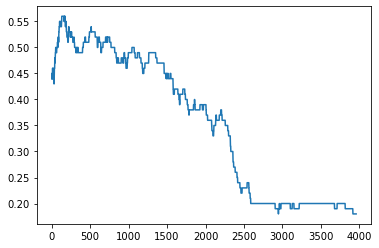

In [988]:
G_init, M, system_hamiltonian, J, mg = simulate(0.1)
t = np.arange(0, len(system_hamiltonian))
plt.plot(t, mg)

In [986]:
G_init.reshape(10,10)

array([[0, 0, 0, 1, 0, 0, 1, 1, 1, 0],
       [1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
       [1, 1, 0, 1, 0, 1, 1, 1, 0, 1],
       [0, 1, 1, 0, 0, 1, 0, 0, 0, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 0, 0, 0, 1, 1, 1, 0, 1],
       [0, 0, 0, 1, 1, 1, 1, 0, 1, 1],
       [1, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [1, 1, 0, 0, 1, 0, 0, 0, 1, 0],
       [1, 0, 1, 0, 0, 0, 1, 0, 0, 1]])

In [987]:
M.reshape(10,10)

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

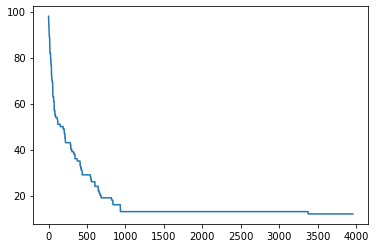

In [979]:
import matplotlib.pyplot as plt

t = np.arange(0, len(system_hamiltonian))

plt.plot(t, system_hamiltonian)

In [965]:
# this does not work right yet, i think probability calculation is not right

T = np.arange(0.001, 5, 1)

magnets = []

for temperature in T:
    G_init, M, system_hamiltonian, J, mg = simulate(temperature)
    magnets.append(mg[-1])

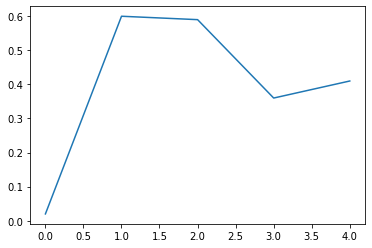

In [966]:
plt.plot(T, magnets)

1.0


<ipython-input-982-2f74cb99067b>:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


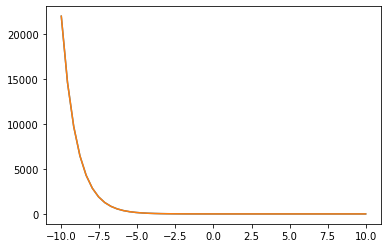

In [982]:
f = lambda beta, dE: np.exp(-beta * dE)
T = 1
beta = 1/ T
print(beta)
dE = np.linspace(-10, 10)

fig, ax = plt.subplots()
ax.plot(dE, f(dE, beta))
ax.plot(dE, f(dE, beta))

fig.show()